# Exploratory Data Analysis

In [51]:
import sqlite3
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm.notebook import tqdm
from typing import Union, List
from collections import defaultdict 

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

proj_path = Path().absolute().parent
data_path = proj_path / 'data' 

# set font family
plt.rcParams["font.family"] = 'NanumGothic'


# SQLite3 Database

```
airmeasure
-------------------------------------
sid           INTEGER PRIMARY KEY
measure_code  INTEGER NOT NULL UNIQUE
district      TEXT 
measure_name  TEXT
address       TEXT
measure_point TEXT
```

```
airquality
-------------------------------------
airid         INTEGER PRIMARY KEY
measure_code  INTEGER
datetime      TEXT
SO2           REAL
CO            REAL
O3            REAL
NO2           REAL
PM10          REAL
PM25          REAL
```

```
holiday
-------------------------------------
hid   INTEGER PRIMARY KEY
date  TEXT
day   TEXT
name  TEXT
type  TEXT
```

```
weather
-------------------------------------
wid INTEGER PRIMARY KEY
measure_code            INTEGER
measure_name            TEXT
datetime                TEXT
temperature             REAL
temperature_flag        REAL
precipitation           REAL
precipitation_flag      REAL
wind_speed              REAL
wind_speed_flag         REAL
wind_direction          REAL
wind_direction_flag     REAL
humidity                REAL
humidity_flag           REAL
vapor_pressure          REAL
dew_point_temperature   REAL
local_pressure          REAL
local_pressure_flag     REAL
sea_level_pressure      REAL
sea_level_pressure_flag REAL
sunshine                REAL
sunshine_flag           REAL
solar_radiation         REAL
solar_radiation_flag    REAL
snow                    REAL
snow_3hour              REAL
cloud                   REAL
mid_level_cloud         REAL
cloud_type              TEXT
lowest_cloud            REAL
visibility              INTEGER
ground_status_code      REAL
weather_status_code     REAL
ground_temperature      REAL
ground_temperature_flag REAL
5cm_soil_temperature    REAL
10cm_soil_temperature   REAL
20cm_soil_temperature   REAL
30cm_soil_temperature   REAL
```



In [52]:
class DBEngine:
    """SQLite3 DB Engine Wrapper"""
    def __init__(self, db_path: Union[str, Path]):
        self.conn = sqlite3.connect(db_path)

    def query(self, sql_statement: str):
        cur = self.conn.cursor()
        res = cur.execute(sql_statement)
        res = res.fetchall()
        cur.close()
        return res

    def quit(self):
        self.conn.close()

    def _sql(self, query:str):
        # no auto commit
        cur = self.conn.cursor()
        cur.execute(query)
        self.conn.commit()
        cur.close()

    def insert(self, query:str):
        return self._sql(query)

    def update(self, query:str):
        return self._sql(query)
        
db = DBEngine(db_path=data_path / "airpollution.db")

# EDA

## Airquality

```
airmeasure
-------------------------------------
sid           INTEGER PRIMARY KEY
measure_code  INTEGER NOT NULL UNIQUE
district      TEXT 
measure_name  TEXT
address       TEXT
measure_point TEXT
```

```
airquality
-------------------------------------
airid         INTEGER PRIMARY KEY
measure_code  INTEGER
datetime      TEXT
SO2           REAL
CO            REAL
O3            REAL
NO2           REAL
PM10          REAL
PM25          REAL
```

In [53]:
# What is the date range?
sql = """
SELECT MIN(datetime), MAX(datetime)
FROM airquality
"""
res = db.query(sql)
pd.DataFrame(res).rename(columns=dict(enumerate(['min', 'max'])))

,min,max
0,2018-01-01 00:00:00,2021-07-31 23:00:00


In [54]:
# What is the number of unique data districts?
sql = """
SELECT COUNT(DISTINCT measure_code)
FROM airmeasure
"""
res = db.query(sql)
res[0][0]

40

In [55]:
# How is each data in the air for each district?
sql = """
SELECT am.district, aq.datetime, aq.SO2, aq.CO, aq.O3, aq.NO2, aq.PM10, aq.PM25
FROM airquality AS aq
JOIN airmeasure AS am
ON aq.measure_code = am.measure_code
GROUP BY am.district, aq.datetime
ORDER BY am.district, aq.datetime
"""
res = db.query(sql)
columns = ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']
df = pd.DataFrame(res).rename(columns=dict(enumerate(['district', 'datetime'] + columns)))
df['datetime'] = pd.to_datetime(df['datetime'])

In [56]:
# Data Statics on airquality values for each district? (null values)
# How to fill these null values?
# We can fill with data in previous day, assume the data will not change dramatically.
# Or resample the value by other time stamp
df.groupby(['district'])[columns].apply(lambda x: len(x) - x.count())

,SO2,CO,O3,NO2,PM10,PM25
district,,,,,,
서울 강남구,1061,842,904,840,683,613
서울 강동구,880,277,402,471,931,653
서울 강북구,318,339,287,340,415,308
서울 강서구,702,284,254,1237,510,307
서울 관악구,1060,1164,1600,1206,1845,1847
서울 광진구,1872,1448,922,602,1196,956
서울 구로구,764,466,519,1061,1885,1327
서울 금천구,334,399,389,513,609,554
서울 노원구,283,295,268,657,450,439


In [ ]:
# see if the missing values are more than 1day
df_group = df.groupby([df.index.get_level_values(0)] + [pd.Grouper(freq='1D', level=-1)]).apply(lambda x: x.isnull().sum() == 24)
# example
df.loc[(df.index.get_level_values(0) == 111121) & 
    (df.index.get_level_values(1) <='2020-05-24 23:00:00') & 
    (df.index.get_level_values(1) > '2020-05-22 23:00:00') ]

In [57]:
def draw(typ, df, freq=None):
    if freq is None:
        df_temp = df
    else:
        df_temp = df.set_index(['district', 'datetime'])
        df_temp = df_temp.groupby([df_temp.index.get_level_values(0)] + [pd.Grouper(freq=freq, level=-1)]).mean()

    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    sns.lineplot(x='datetime', y=typ, hue='district', data=df_temp, linewidth=0.5, ax=ax)
    ax.set_title(f'{typ} value (freq:{"1 Hour" if freq is None else freq})', fontsize=14)
    ax.legend(bbox_to_anchor=(1.15, 1.1))
    plt.show()

w_typ = widgets.Dropdown(
    options=columns,
    description='type:',
    disabled=False,
)

w_freq = widgets.Dropdown(
    options=[None, '1D', '1W', '1M'],
    value='1M',
    description='freq:',
    disabled=False,
)

ui = widgets.HBox([w_typ, w_freq])

out = widgets.interactive_output(draw, {'typ': w_typ, 'df': widgets.fixed(df), 'freq': w_freq})
display(ui, out)

Output()

## Weather


```
weather
-------------------------------------
wid INTEGER PRIMARY KEY
measure_code            INTEGER
measure_name            TEXT
datetime                TEXT
temperature             REAL
temperature_flag        REAL
precipitation           REAL
precipitation_flag      REAL
wind_speed              REAL
wind_speed_flag         REAL
wind_direction          REAL
wind_direction_flag     REAL
humidity                REAL
humidity_flag           REAL
vapor_pressure          REAL
dew_point_temperature   REAL
local_pressure          REAL
local_pressure_flag     REAL
sea_level_pressure      REAL
sea_level_pressure_flag REAL
sunshine                REAL
sunshine_flag           REAL
solar_radiation         REAL
solar_radiation_flag    REAL
snow                    REAL
snow_3hour              REAL
cloud                   REAL
mid_level_cloud         REAL
cloud_type              TEXT
lowest_cloud            REAL
visibility              INTEGER
ground_status_code      REAL
weather_status_code     REAL
ground_temperature      REAL
ground_temperature_flag REAL
5cm_soil_temperature    REAL
10cm_soil_temperature   REAL
20cm_soil_temperature   REAL
30cm_soil_temperature   REAL
```


In [8]:
# What is the date range?
sql = """
SELECT MIN(datetime), MAX(datetime)
FROM weather
"""
res = db.query(sql)
pd.DataFrame(res).rename(columns=dict(enumerate(['min', 'max'])))

,min,max
0,2018-01-01 00:00:00,2021-07-31 23:00:00


In [9]:
# What is the number of unique data districts?
sql = """
SELECT DISTINCT measure_name
FROM weather
"""
res = db.query(sql)
print(res[0][0])
# only single district

서울


In [41]:
# 
sql = """
SELECT 
    datetime, temperature, temperature_flag, precipitation, precipitation_flag, wind_speed, wind_speed_flag,
    wind_direction, wind_direction_flag, humidity, humidity_flag, vapor_pressure, dew_point_temperature, 
    local_pressure, local_pressure_flag, sea_level_pressure, sea_level_pressure_flag, sunshine, sunshine_flag, 
    solar_radiation, solar_radiation_flag, snow, snow_3hour, cloud, mid_level_cloud, cloud_type, lowest_cloud,
    visibility, ground_status_code, weather_status_code, ground_temperature, ground_temperature_flag,
    "5cm_soil_temperature", "10cm_soil_temperature", "20cm_soil_temperature", "30cm_soil_temperature"
FROM weather
"""
res = db.query(sql)
columns = [
    'datetime', 'temperature', 'temperature_flag', 'precipitation', 'precipitation_flag', 'wind_speed', 'wind_speed_flag',
    'wind_direction', 'wind_direction_flag', 'humidity', 'humidity_flag', 'vapor_pressure', 'dew_point_temperature', 
    'local_pressure', 'local_pressure_flag', 'sea_level_pressure', 'sea_level_pressure_flag', 'sunshine', 'sunshine_flag', 
    'solar_radiation', 'solar_radiation_flag', 'snow', 'snow_3hour', 'cloud', 'mid_level_cloud', 'cloud_type', 'lowest_cloud',
    'visibility', 'ground_status_code', 'weather_status_code', 'ground_temperature', 'ground_temperature_flag',
    '5cm_soil_temperature', '10cm_soil_temperature', '20cm_soil_temperature', '30cm_soil_temperature'
]
df = pd.DataFrame(res).rename(columns=dict(enumerate(columns)))
df['datetime'] = pd.to_datetime(df['datetime'])

In [31]:
def check_data_with_flag(df, check_column, print_res=False):
    check_cs = [check_column, f'{check_column}_flag']
    df_temp = df.loc[:, ['datetime'] + check_cs]
    unique_values = df_temp[f'{check_column}_flag'].unique()
    if print_res:
        print(f'Unique values in "{check_column}":', unique_values)
        print(f'Number of Nulls in "{check_column}":')
    cl = []
    for x in unique_values:
        df_temperature = df_temp.loc[df_temp[f'{check_column}_flag'].isin([x]), check_column]
        number_of_data = len(df_temperature)
        number_of_null = df_temperature.isnull().sum()
        cl.append([x, number_of_null, number_of_data])
        if print_res:
            print(f'- {x}: {number_of_null} / {number_of_data}')
    return cl

In [32]:
# check nulls for flag columns
# c, cl, null, data
check_columns = [
    'temperature', 'precipitation', 'wind_speed', 'wind_direction', 'humidity', 'local_pressure', 'sea_level_pressure', 
    'sunshine', 'solar_radiation', 'ground_temperature'
]
c_dict = {'column': [], 'flag_value': [], 'number_of_null': [], 'number_of_data': []}
for c in check_columns:
    cl = check_data_with_flag(df, check_column=c)
    values, number_of_nulls, number_of_datas = list(zip(*cl))
    c_dict['column'] += [c] * len(cl)
    c_dict['flag_value'] += values
    c_dict['number_of_null'] += number_of_nulls
    c_dict['number_of_data'] += number_of_datas

pd.DataFrame(c_dict).set_index(['column', 'flag_value']).sort_index()

number_of_null  number_of_data
column             flag_value                                
ground_temperature 0.0                      0            7696
                   9.0                     23              24
                   NaN                      0           23672
humidity           0.0                      0            7594
                   NaN                      0           23798
local_pressure     0.0                      0            7594
                   1.0                      3               3
                   9.0                     10              10
                   NaN                      0           23785
precipitation      0.0                      0             633
                   9.0                   5564            5566
                   NaN                  22507           25193
sea_level_pressure 0.0                      0            7594
                   1.0                      3               3
                   9.0                     10              10
                   NaN                      0           23785
solar_radiation    0.0                      0            3847
                   9.0                  14135           14135
                   NaN                      2           13410
sunshine           0.0                      0            3845
                   9.0                  14135           14135
                   NaN                      2           13412
temperature        0.0                      0            7622
                   1.0                      1               1
                   9.0                      1               1
                   NaN                      0           23768
wind_direction     0.0                      0            7245
                   9.0                      9               9
                   NaN                      2           24138
wind_speed         0.0                      0            7245
                   9.0                      9               9
                   NaN                      2           24138

<ipython-input-33-21c9ca7c1b01>:6: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/simonjisu/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


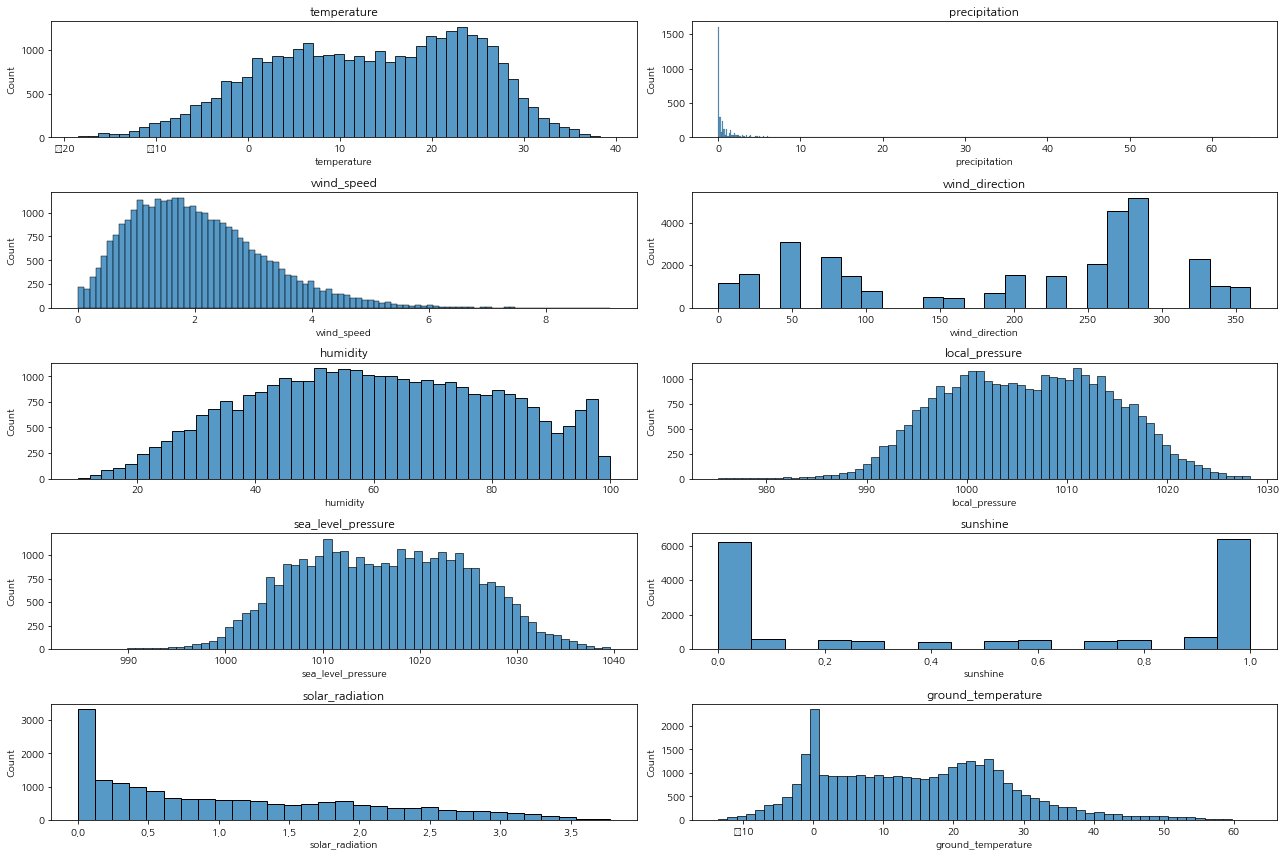

In [33]:
fig, axes = plt.subplots(len(check_columns) // 2, 2, figsize=(18, 12))
for ax, c in zip(axes.flatten(), check_columns):
    sns.histplot(x=c, data=df, ax=ax)
    ax.set_title(c)

plt.tight_layout()
plt.show()

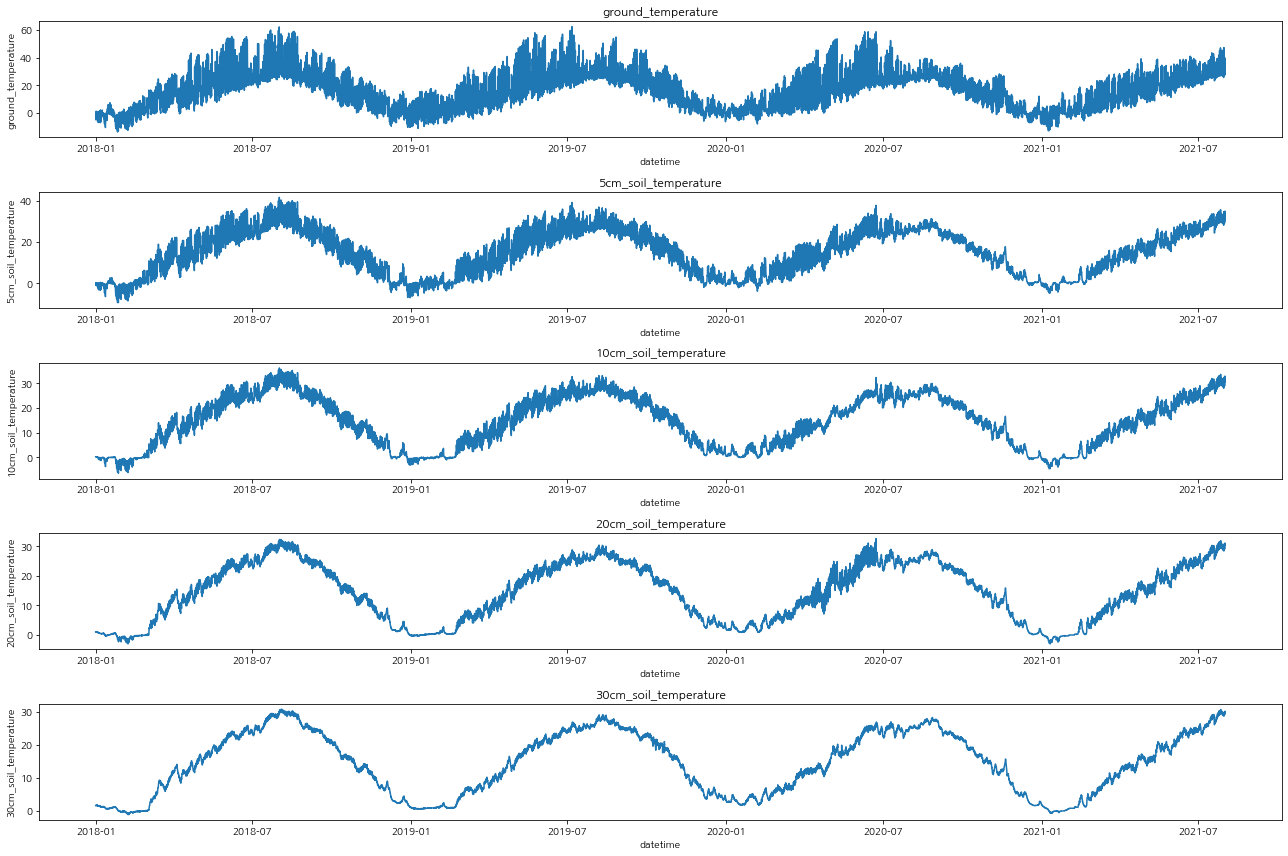

In [34]:
check_columns = ['ground_temperature', '5cm_soil_temperature', '10cm_soil_temperature', '20cm_soil_temperature', '30cm_soil_temperature']

fig, axes = plt.subplots(len(check_columns), 1, figsize=(18, 12))
for ax, c in zip(axes.flatten(), check_columns):
    sns.lineplot(x='datetime', y=c, data=df, ax=ax)
    ax.set_title(c)

plt.tight_layout()
plt.show()

In [50]:
check_columns = ['ground_status_code', 'weather_status_code', 'visibility', 'dew_point_temperature']
for c in check_columns:
    print(c, len(df[c].unique()))

ground_status_code 1
weather_status_code 66
visibility 1924
dew_point_temperature 568
